In [82]:
import os
import pandas as pd
import numpy as np
import seaborn_image as isns
from pathlib import Path
import imageio
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
import seaborn as sb
import pprint
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
import imagehash
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn import tree
from sklearn import metrics
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD, RMSprop
import graphviz
import pydotplus
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score

plt.rcParams['figure.figsize'] = [2.0, 2.0]
plt.rcParams['figure.dpi'] = 80
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False



In [2]:
files = []

for dirname, _, filenames in os.walk('./2750'):
    for filename in filenames:
        if ".jpg" in filename:
            name = "" + os.path.join(dirname, filename)
            files.append(name)
            #print(name)


print(files[0])
print(len(files))
            



./2750\AnnualCrop\AnnualCrop_1.jpg
27000


In [4]:
#Создаем пустые списки
raw_images = np.zeros([len(files),64, 64, 3])
io_img = list()
cv_img = []

print(len(raw_images))
print(type(raw_images))

27000
<class 'numpy.ndarray'>


Loading completed
AxesImage(20,20;124x120.8)


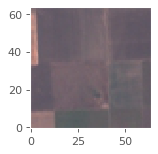

In [5]:
# Загружаем наши картинки
i=0
for img in files:
    #raw_images[i] = np.asarray(Image.open(Path(img))).astype('uint8')
    raw_images[i] = np.asarray(Image.open(Path(img))).astype('uint8')/255
    io_img.append(imageio.imread(Path(img)))
    cv_img.append(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))
    i = i+1
    #raw_images[i].show()

#print(raw_images[1])
print('Loading completed')
print(plt.imshow(io_img[0]))

In [6]:
labels = np.empty(len(files), dtype = 'S50')

i = 0
for label in files:
#    labels[i] = label.split('/')[2] #Mac
    labels[i] = label.split('\\')[1] #Windows
    i += 1

print(labels)

[b'AnnualCrop' b'AnnualCrop' b'AnnualCrop' ... b'SeaLake' b'SeaLake'
 b'SeaLake']


In [7]:
# Делаем из наших классов словарь
label_names, yLabels = np.unique(labels, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
pprint.pprint(label_Dict)
np.array(np.unique(yLabels, return_counts=True))

{0: b'AnnualCrop',
 1: b'Forest',
 2: b'HerbaceousVegetation',
 3: b'Highway',
 4: b'Industrial',
 5: b'Pasture',
 6: b'PermanentCrop',
 7: b'Residential',
 8: b'River',
 9: b'SeaLake'}


array([[   0,    1,    2,    3,    4,    5,    6,    7,    8,    9],
       [3000, 3000, 3000, 2500, 2500, 2000, 2500, 3000, 2500, 3000]],
      dtype=int64)

0
b'AnnualCrop'
raw:


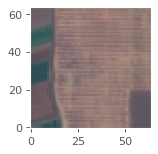

In [8]:
# Выведем значение из словаря и картинку
tmp = 2999
#img = raw_images[tmp]
img = io_img[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
print("raw:")
#print(img)
#pplt.imshow(img);
plt.imshow(img.astype('uint8'));


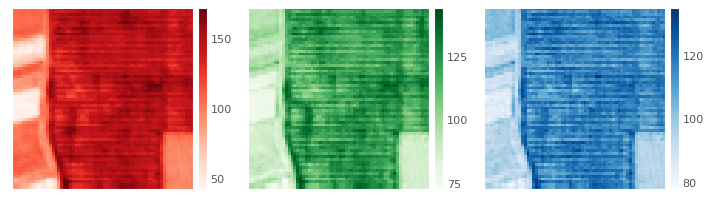

In [9]:
# Выведем картинку поканально
isns.rgbplot(io_img[tmp])

In [10]:
# При этом в io_img лежат картинки 64x64x3 в формате int
io_img[1].shape


(64, 64, 3)

In [11]:
io_img[1][1,1]

Array([55, 97, 83], dtype=uint8)

In [12]:
# А в raw_images лежат такие же картинки, только каждый пиксель имеет тип float и интенсивность от 0 до 1
raw_images[1][1,1]

array([0.21568627, 0.38039216, 0.3254902 ])

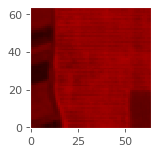

In [13]:
#Мы можем вывести каналы отдельно, выбирая тот или иной канал
red1 = np.zeros_like(io_img[tmp])
red1[:,:,0] = io_img[tmp][:,:,0] 
plt.imshow(red1)

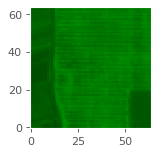

In [14]:
green = np.zeros_like(io_img[tmp])
green[:,:,1] = img[:,:,1] 
plt.imshow(green)

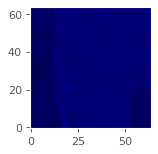

In [15]:
blue = np.zeros_like(io_img[tmp])
blue[:,:,2] = img[:,:,2]
plt.imshow(blue)

In [16]:
# Изначально была идея посчитать какие-либо параметры на основе нашего изображения.
#Затем перевести всё это в отдельный датасет, и работать уже с ним ( без изображений )

# Тут функции для вычисления 
# медианных значений по каналу, суммарных значений по каналу
# Нахождения максимального и минимального значений в каналах
# Рассчёт luminocity ( Яркость для каждого канала ) + её максимальные и минимальные значения
# Определение среднего цвета
# Дистанция между самым интенсивным ( сумма всех каналов ) и самым тусклым пикселем

def get_channel(pic1, ch):
    ch1 = np.zeros_like(pic1)
    ch1[:,:,ch] = pic1[:,:, ch]
    return ch1

def get_red_channel(pic):
    #red1 = np.zeros_like(pic)
    #red1[:,:,0] = pic[:,:,0]
    return get_channel(pic, 0)

def get_green_channel(pic):
    #green1 = np.zeros_like(pic)
    #green1[:,:,1] = pic[:,:,1]
    return get_channel(pic, 1)

def get_blue_channel(pic):
    #blue1 = np.zeros_like(pic)
    #blue1[:,:,2] = pic[:,:,2]
    return get_channel(pic, 2)

def get_red_channel_only(pic):
    #red1 = np.zeros_like(pic)
    #red1[:,:,0] = pic[:,:,0]
    return get_channel(pic, 0)[:,:,0]

def get_green_channel_only(pic):
    #green1 = np.zeros_like(pic)
    #green1[:,:,1] = pic[:,:,1]
    return get_channel(pic, 1)[:,:,1]

def get_blue_channel_only(pic):
    #blue1 = np.zeros_like(pic)
    #blue1[:,:,2] = pic[:,:,2]
    return get_channel(pic, 2)[:,:,2]

def display_blue(pic):
    #blue1 = np.zeros_like(io[i])
    #blue1[:,:,2] = img[:,:,2]
    blue1 = get_blue_channel(pic)
    plt.imshow(blue1)
    
def display_green(pic):
    #green1 = np.zeros_like(io[i])
    #green1[:,:,1] = img[:,:,1]
    green1 = get_green_channel(pic)
    plt.imshow(green1)
    
def display_red(pic):
    red1 = get_red_channel(pic)
    plt.imshow(red1)

def element_tuple_idx(arr, tpl):
    idx0 = tpl[0]
    idx1 = tpl[1]
    idx2 = tpl[2]
    idx3 = tpl[3]
    return arr[idx0, idx1, idx2, idx3]

def draw_image_with_idx(draw_idx):
    plt.imshow(io_img[draw_idx])
    
def find_max_px_by_channel(pic, ch):
    mx = pic[:,:,ch];
    return mx.max()

def find_min_px_by_channel(pic, ch):
    mn = pic[:,:,ch];
    return mn.min()

def get_max_px_coord_by_channel(pic, ch):
    ch2 = pic[:,:, ch]
    return np.unravel_index(ch2.argmax(), ch2.shape)

def get_min_px_coord_by_channel(pic, ch):
    ch2 = pic[:,:, ch]
    return np.unravel_index(ch2.argmin(), ch2.shape)

def find_max(pic):
    br = pic.sum(axis=2)
    return br.max()

def find_min(pic):
    br = pic.sum(axis=2)
    return br.min()

def get_max_coord(pic):
    br = pic.sum(axis=2)
    return np.unravel_index(br.argmax(), br.shape)

def get_min_coord(pic):
    br = pic.sum(axis=2)
    return np.unravel_index(br.argmin(), br.shape)

def get_sum_channels(pic):
    ch1 = pic[:,:, 0].flatten().sum()
    ch2 = pic[:,:, 1].flatten().sum()
    ch3 = pic[:,:, 2].flatten().sum()
    return ch1, ch2, ch3

def get_mean_channels(pic):
    ch1 = np.around(pic[:,:, 0].flatten().mean(), decimals = 3)
    ch2 = np.around(pic[:,:, 1].flatten().mean(), decimals = 3)
    ch3 = np.around(pic[:,:, 2].flatten().mean(), decimals = 3)
    return ch1, ch2, ch3

def get_median_channels(pic):
    ch1 = np.median(pic[:,:, 0].flatten())
    ch2 = np.median(pic[:,:, 1].flatten())
    ch3 = np.median(pic[:,:, 2].flatten())
    return ch1, ch2, ch3

def get_distance(x, y):
    return distance.euclidean(x, y)

def get_distance_red(pic):
    return get_distance(get_max_px_coord_by_channel(pic, 0), get_min_px_coord_by_channel(pic, 0))

def get_distance_green(pic):
    return get_distance(get_max_px_coord_by_channel(pic, 1), get_min_px_coord_by_channel(pic, 1))

def get_distance_blue(pic):
    return get_distance(get_max_px_coord_by_channel(pic, 2), get_min_px_coord_by_channel(pic, 2))

def get_multy_distance(pic):
    return get_distance(get_max_coord(pic), get_min_coord(pic))

#Luminance (standard for certain colour spaces): (0.2126*R + 0.7152*G + 0.0722*B)
def lum(px):
    return 0.2126*px[0]+0.7152*px[1]+0.0722*px[2]

def lum_max(pic):
    lm = np.apply_along_axis(lum, 2, pic)
    return lm.max()

def lum_min(pic):
    lm = np.apply_along_axis(lum, 2, pic)
    return lm.min()

def lum_distance(pic):
    lm = np.apply_along_axis(lum, 2, pic)
    return get_distance(np.unravel_index(lm.argmax(), lm.shape), np.unravel_index(lm.argmin(), lm.shape))

def get_dominant_color(pic):
    pi = Image.fromarray(pic)
    pi = pi.resize((1, 1), resample=0)
    r = np.asarray(pi.getpixel((0, 0))).astype('uint8')
    return r[0], r[1], r[2]


def plot_image_by_index(img_index, height=6):
    img = io[img_index]
    sb.histplot(data=penguins, y="flipper_length_mm")
    

def plot_tree(model, X, fname='temp_tree.png'):
    dot_data = export_graphviz(model, filled=True, rounded=True, feature_names=X.columns, out_file=None)
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

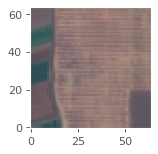

In [17]:
# Отрисуем картинку с помощью функции
draw_image_with_idx(tmp)

In [18]:
# Функция для определения наиболее используемых цветов
def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
        print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect

[57.53164557 85.2278481  88.29113924] 5.79%
[134.13333333 111.21333333 109.62666667] 16.48%
[100.72360617  90.57295374  96.84223013] 20.58%
[155.77756286 129.22533849 122.40232108] 25.24%
[145.9441469  120.75592961 116.27467483] 31.91%


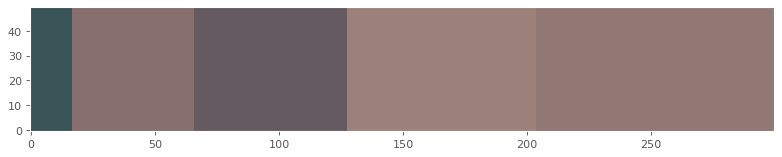

In [19]:
# Попробуем ей воспользоваться
pic = io_img[tmp]
reshape = pic.reshape((pic.shape[0] * pic.shape[1], 3))
reshape.shape

cluster = KMeans(n_clusters=5).fit(reshape)
cluster

visualize = visualize_colors(cluster, cluster.cluster_centers_)
plt.figure(figsize=[12,4])
plt.imshow(visualize)
plt.show()

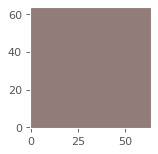

In [20]:
# А теперь посмотрим, какой у нас получился доминантный цвет при сжатии картинки до 1 пикселя
# Похоже на правду. Пока будем использовать его
pic = io_img[tmp]
dc = get_dominant_color(pic)
ppx = np.zeros_like(pic)
ppx[:,:,0] = dc[0]
ppx[:,:,1] = dc[1]
ppx[:,:,2] = dc[2]
plt.imshow(ppx)
plt.show()

In [29]:
#######MY_DATASETS##############

### (Эту часть нужно проходить последней) My Dataset  (пробуем сами что-то сделать и посчитаь)

In [21]:
len(files)

27000

In [22]:
len(io_img)

27000

In [323]:
# !!! Warning  !!!
# Приключение на 1 час - уже сохранено в файл. Не нужно выполнять
df_stat = pd.DataFrame(columns = ['id','class','z_max', 'z_min', 'z_mm_dst','r_sum', 'r_max', 'r_min', 'r_mm_dst', 'r_median', 'g_sum', 'g_max', 'g_min', 'g_mm_dst', 'g_median', 'b_sum', 'b_max', 'b_min', 'b_mm_dst', 'b_median', 'lum_max', 'lum_min', 'lum_dst', 'dom_r', 'dom_g', 'dom_b'])

i=0
for img in io_img:
    c_id = i
    c_class = yLabels[i]
    c_z_max = find_max(img)
    c_z_min = find_min(img)
    c_z_mm_dst = get_multy_distance(img)
    
    c_r_sum, c_g_sum, c_b_sum = get_sum_channels(img)
    c_r_median, c_g_median, c_b_median = get_median_channels(img)
    
    c_r_max = find_max_px_by_channel(img, 0)
    c_g_max = find_max_px_by_channel(img, 1)
    c_b_max = find_max_px_by_channel(img, 2)
    
    c_r_min = find_min_px_by_channel(img, 0)
    c_g_min = find_min_px_by_channel(img, 1)
    c_b_min = find_min_px_by_channel(img, 2)
    
    c_r_mm_dst = get_distance_red(img)
    c_g_mm_dst = get_distance_green(img)
    c_b_mm_dst = get_distance_blue(img)
    
    c_lum_max = lum_max(img)
    c_lum_min = lum_min(img)
    c_lum_dst = lum_distance(img)
    
    c_dom_r, c_dom_g, c_dom_b = get_dominant_color(img)
    
    df_stat.loc[i] = [c_id, c_class, c_z_max, c_z_min, c_z_mm_dst, c_r_sum, c_r_max, c_r_min, c_r_mm_dst, c_r_median, c_g_sum, c_g_max, c_g_min, c_g_mm_dst, c_g_median, c_b_sum, c_b_max, c_b_min, c_b_mm_dst, c_b_median, c_lum_max, c_lum_min, c_lum_dst, c_dom_r, c_dom_g, c_dom_b]
    
    if (i % 100 == 0):
        print(i)
    i = i + 1

len(df_stat)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

27000

In [32]:
# Сохраним наш датафрейм, т.к. собиралось 1 час
#pd.DataFrame(df_stat).to_pickle("df_stat.pkl")
#(если надо сохранить)

In [23]:
df_stat = pd.read_pickle("df_stat.pkl")
len(df_stat)

27000

In [24]:
# Посмотрим на полученные данные
df_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000 entries, 0 to 26999
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        27000 non-null  float64
 1   class     27000 non-null  float64
 2   z_max     27000 non-null  float64
 3   z_min     27000 non-null  float64
 4   z_mm_dst  27000 non-null  float64
 5   r_sum     27000 non-null  float64
 6   r_max     27000 non-null  float64
 7   r_min     27000 non-null  float64
 8   r_mm_dst  27000 non-null  float64
 9   r_median  27000 non-null  float64
 10  g_sum     27000 non-null  float64
 11  g_max     27000 non-null  float64
 12  g_min     27000 non-null  float64
 13  g_mm_dst  27000 non-null  float64
 14  g_median  27000 non-null  float64
 15  b_sum     27000 non-null  float64
 16  b_max     27000 non-null  float64
 17  b_min     27000 non-null  float64
 18  b_mm_dst  27000 non-null  float64
 19  b_median  27000 non-null  float64
 20  lum_max   27000 non-null  fl

In [25]:
df_stat.head()

,id,class,z_max,z_min,z_mm_dst,r_sum,r_max,r_min,r_mm_dst,r_median,...,b_max,b_min,b_mm_dst,b_median,lum_max,lum_min,lum_dst,dom_r,dom_g,dom_b
0,0.0,0.0,515.0,264.0,40.816663,446883.0,211.0,81.0,42.190046,105.0,...,152.0,92.0,43.416587,104.0,167.5590,86.4950,59.135438,116.0,100.0,103.0
1,1.0,0.0,521.0,166.0,46.173586,410541.0,219.0,35.0,48.270074,56.0,...,144.0,65.0,35.355339,86.0,175.4050,56.6878,45.099889,55.0,98.0,81.0
2,2.0,0.0,578.0,247.0,62.393910,731426.0,221.0,61.0,63.324561,192.0,...,178.0,94.0,62.201286,148.0,190.4290,84.2534,67.082039,184.0,149.0,143.0
3,3.0,0.0,641.0,217.0,39.849718,628144.0,247.0,50.0,39.849718,184.0,...,188.0,86.0,39.849718,145.0,213.4170,74.7704,39.849718,192.0,160.0,147.0
4,4.0,0.0,496.0,217.0,28.460499,480218.0,187.0,49.0,15.524175,132.0,...,154.0,88.0,19.416488,127.0,164.1586,71.5554,18.973666,68.0,86.0,96.0


In [26]:
# Не очень хорошо получилось, сконвертим в целые числа
df_stat = df_stat.convert_dtypes()
df_stat.head()

,id,class,z_max,z_min,z_mm_dst,r_sum,r_max,r_min,r_mm_dst,r_median,...,b_max,b_min,b_mm_dst,b_median,lum_max,lum_min,lum_dst,dom_r,dom_g,dom_b
0,0,0,515,264,40.816663,446883,211,81,42.190046,105.0,...,152,92,43.416587,104.0,167.559,86.495,59.135438,116,100,103
1,1,0,521,166,46.173586,410541,219,35,48.270074,56.0,...,144,65,35.355339,86.0,175.405,56.6878,45.099889,55,98,81
2,2,0,578,247,62.39391,731426,221,61,63.324561,192.0,...,178,94,62.201286,148.0,190.429,84.2534,67.082039,184,149,143
3,3,0,641,217,39.849718,628144,247,50,39.849718,184.0,...,188,86,39.849718,145.0,213.417,74.7704,39.849718,192,160,147
4,4,0,496,217,28.460499,480218,187,49,15.524175,132.0,...,154,88,19.416488,127.0,164.1586,71.5554,18.973666,68,86,96


In [27]:
df_stat.corr()

,id,class,z_max,z_min,z_mm_dst,r_sum,r_max,r_min,r_mm_dst,r_median,...,b_max,b_min,b_mm_dst,b_median,lum_max,lum_min,lum_dst,dom_r,dom_g,dom_b
id,1.000000,0.994057,0.010814,-0.070130,0.005768,-0.207105,-0.070223,-0.126627,-0.013062,-0.213522,...,0.096677,0.022901,-0.008800,-0.055327,0.009125,-0.093646,0.018842,-0.178533,-0.125607,-0.041969
class,0.994057,1.000000,0.010175,-0.063797,0.005881,-0.203034,-0.068277,-0.121483,-0.013656,-0.208538,...,0.093525,0.026802,-0.009529,-0.053574,0.008617,-0.086348,0.018667,-0.176647,-0.124678,-0.043771
z_max,0.010814,0.010175,1.000000,0.322553,-0.017135,0.698279,0.975150,0.345116,0.017757,0.636506,...,0.977668,0.189338,-0.011449,0.640453,0.999054,0.325677,-0.027571,0.594685,0.591182,0.579372
z_min,-0.070130,-0.063797,0.322553,1.000000,0.027775,0.704492,0.351073,0.949906,0.054887,0.703990,...,0.277805,0.893556,0.042974,0.772729,0.323730,0.988886,0.026719,0.576078,0.584396,0.571123
z_mm_dst,0.005768,0.005881,-0.017135,0.027775,1.000000,0.010577,-0.009183,0.016870,0.506583,0.010372,...,-0.024583,0.038505,0.481010,0.008479,-0.016764,0.032440,0.753399,0.012524,0.011915,0.006049
r_sum,-0.207105,-0.203034,0.698279,0.704492,0.010577,1.000000,0.744266,0.757232,0.063176,0.984802,...,0.616383,0.480433,0.030063,0.885325,0.701501,0.715535,0.004754,0.849307,0.789437,0.718158
r_max,-0.070223,-0.068277,0.975150,0.351073,-0.009183,0.744266,1.000000,0.389714,0.027655,0.683631,...,0.912456,0.185250,-0.007234,0.632064,0.973578,0.360950,-0.020221,0.624666,0.599650,0.558611
r_min,-0.126627,-0.121483,0.345116,0.949906,0.016870,0.757232,0.389714,1.000000,0.052076,0.754469,...,0.279137,0.749368,0.036687,0.724252,0.348558,0.942893,0.016526,0.618646,0.587144,0.534554
r_mm_dst,-0.013062,-0.013656,0.017757,0.054887,0.506583,0.063176,0.027655,0.052076,1.000000,0.062914,...,0.007287,0.045092,0.336461,0.051944,0.018479,0.060715,0.439020,0.052024,0.049178,0.036850
r_median,-0.213522,-0.208538,0.636506,0.703990,0.010372,0.984802,0.683631,0.754469,0.062914,1.000000,...,0.555421,0.482684,0.031182,0.885885,0.640008,0.716183,0.005869,0.841654,0.773072,0.697977


In [28]:
#Как и ожидалось, параметры сильно коррелируют между собой

In [29]:
k = 10 
corrmat = abs(df_stat.corr())
cols = corrmat.nlargest(k, 'class')['class'].index.tolist()
cols

['class',
 'id',
 'r_median',
 'r_sum',
 'dom_r',
 'g_median',
 'g_sum',
 'dom_g',
 'r_min',
 'b_max']

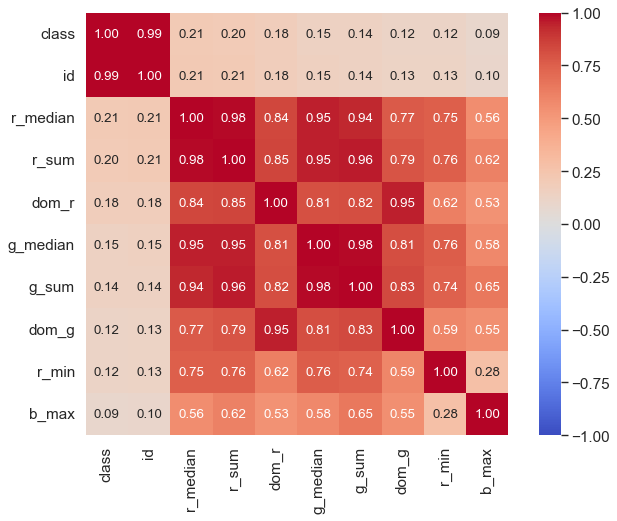

In [30]:
cm = abs(df_stat[cols].corr())
plt.figure(figsize=(10,7))
sb.set(font_scale=1.25)
sb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                    cmap=sb.color_palette('coolwarm',1000))
plt.show()

In [40]:
# Похоже, что интенсивность цветов на кортинке примерно совпадает.
# Хотя g_median и r_median и коррелируют между собой, предлагаю их убрать, а r_sum, g_sum, b_sum выкинуть

In [41]:
df_stat = df_stat.drop(['r_sum', 'g_sum', 'b_sum'], axis=1);

In [42]:
# Повторяем упражнение

In [43]:
k = 10 
corrmat = abs(df_stat.corr())
cols = corrmat.nlargest(k, 'class')['class'].index.tolist()
cols

['class',
 'id',
 'r_median',
 'dom_r',
 'g_median',
 'dom_g',
 'r_min',
 'b_max',
 'lum_min',
 'g_min']

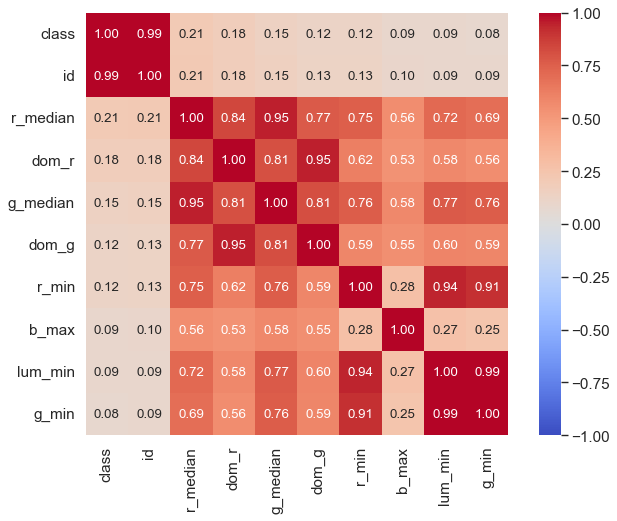

In [44]:
cm = abs(df_stat[cols].corr())
plt.figure(figsize=(10,7))
sb.set(font_scale=1.25)
sb.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                    cmap=sb.color_palette('coolwarm',1000))
plt.show()

In [ ]:
# Смеха ради предлагаю построить модель и посмотреть.

In [72]:
df_tmp = df_stat.drop(['id', 'class'], axis = 1)
labels_tmp = np.array(yLabels)

#For my data
X_train_my, X_test_my, y_train_my, y_test_my = train_test_split(df_tmp, labels_tmp, stratify = yLabels, train_size = 0.4, random_state=42)

rfc_my = RandomForestClassifier(n_jobs=8, random_state=42)
rfc_my.fit(X_train_my, y_train_my)
y_pred_my = rfc_my.predict(X_test_my)

print(metrics.accuracy_score(y_test_my, y_pred_my))
class_report(y_pred_my, y_test_my);

0.717037037037037
              precision    recall  f1-score   support

           0      0.779     0.733     0.755      1913
           1      0.922     0.879     0.900      1887
           2      0.684     0.772     0.725      1595
           3      0.248     0.431     0.315       864
           4      0.873     0.779     0.823      1680
           5      0.744     0.678     0.710      1317
           6      0.599     0.583     0.591      1542
           7      0.781     0.611     0.686      2298
           8      0.571     0.592     0.581      1445
           9      0.883     0.958     0.919      1659

    accuracy                          0.717     16200
   macro avg      0.708     0.702     0.701     16200
weighted avg      0.740     0.717     0.725     16200



In [70]:
feature_importances = zip(X_train_my.columns, rfc_my.feature_importances_)
list(feature_importances)

[('z_max', 0.07676776774073299),
 ('z_min', 0.03981884287416476),
 ('z_mm_dst', 0.02288195435239382),
 ('r_max', 0.06154906373847651),
 ('r_min', 0.047508020478328986),
 ('r_mm_dst', 0.02489567173906721),
 ('r_median', 0.08180005347335444),
 ('g_max', 0.056889914322351576),
 ('g_min', 0.0405227506219532),
 ('g_mm_dst', 0.023573003259144257),
 ('g_median', 0.06096723375493496),
 ('b_max', 0.07188785031814464),
 ('b_min', 0.05122951687640609),
 ('b_mm_dst', 0.02498834295017518),
 ('b_median', 0.05728065182616984),
 ('lum_max', 0.07283198495006891),
 ('lum_min', 0.04366683023713381),
 ('lum_dst', 0.023097903584248985),
 ('dom_r', 0.04468749398330536),
 ('dom_g', 0.03718330208226059),
 ('dom_b', 0.03597184683718384)]

In [67]:
rfc_my.feature_importances_.sum()

1.0

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.135033 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.1398 to fit



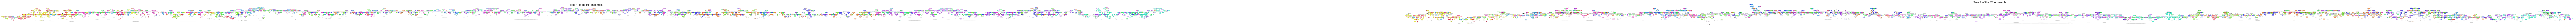

In [71]:
tree1, tree2 = rfc_my.estimators_[0], rfc_my.estimators_[1]

plt.figure(figsize=(250, 150))
plt.subplot(1, 2, 1)
plot_tree(tree1, X_train_my)
plt.axis('off')
plt.title(f'Tree 1 of the RF ensemble')
plt.subplot(1, 2, 2)
plot_tree(tree2, X_train_my)
plt.axis('off')
plt.title(f'Tree 2 of the RF ensemble')
plt.show()

In [42]:
## End #### MY_DATASETS#####

In [43]:
####### ML ################

## 1. ML

In [31]:
def quality_report(prediction, actual, verbose=True):
    acc_s = metrics.accuracy_score(actual, prediction)
    f1 = metrics.f1_score(actual, prediction, average='macro')
    pre = metrics.precision_score(actual, prediction, average='macro')
    rec = metrics.recall_score(actual, prediction, average='macro')


    quality_list = [acc_s, f1, pre, rec]
    
    if verbose:
        report_str = "Accuracy: \t {:.3f}\n" +\
                "F1-Score: \t {:.3f}\n" +\
                "Precision: \t {:.3f}\n" +\
                "Recall: \t {:.3f}\n"
        print("\n=== Quality Report ===")
        print(report_str.format(acc_s, f1, pre, rec))
        print("======================\n")
    
    return quality_list

In [32]:
def class_report(prediction, actual, verbose=True):
    sk_report = metrics.classification_report(
    digits=3,
    y_true=prediction, 
    y_pred=actual)
    
    if verbose:
        print(sk_report)
        
    return sk_report

In [33]:
# Создадим пустой массив для результатов
df_quality = pd.DataFrame(
    columns=["ACC", "F1", "PRE", "REC"]
)

In [35]:
# Загрузим наш массивы в x и y, чтобы не портить исходные
# yLabels and io_img are arrays of integers
x = np.array(raw_images)
y = np.array(yLabels)

Попробуем разбить наши подготовленные данные на тестовые и валидационные:

In [36]:
#For coloured
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify = yLabels, train_size = 0.4, random_state=42)

print(X_train.shape)
print(X_test.shape)

(10800, 64, 64, 3)
(16200, 64, 64, 3)


In [37]:
# GreyScale our images
X_train_gs = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
X_test_gs = np.zeros([X_test.shape[0], X_test.shape[1], X_test.shape[2]])

for i in range(X_train.shape[0]):
    X_train_gs[i] = rgb2gray(X_train[i])
    
for i in range(X_test.shape[0]):
    X_test_gs[i] = rgb2gray(X_test[i])

print(X_train_gs.shape)
print(X_test_gs.shape)


(10800, 64, 64)
(16200, 64, 64)


b'AnnualCrop'


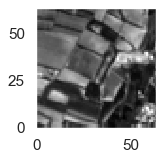

In [39]:
# Посмотрим, что у нас получилось
tmp2 = 15
img = X_train_gs[tmp2]

print(label_names[yLabels[tmp2]])
plt.grid(False)

plt.imshow(img, cmap='gray'); # Без cmap передаём привет монохромным мониторам

In [40]:
# Посмотрим, как у нас представлены пиксели
print(X_train[1][0,0])
print(X_train_gs[1][0,0])

[0.31764706 0.36862745 0.54117647]
0.37023490196078435


Выглядит неплохо. Замечаем, что при переводе из цветного изображения в черно-белое у нас значения пикселя поменялись с int на float. Но это даже хорошо.



b'SeaLake'


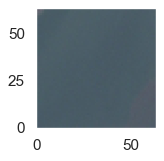

In [42]:
#Посмотрим, что не растеряли лейблы
tmp2 = 8000
img = X_train[tmp2]

print(label_names[y_train[tmp2]])
#plt.imshow(img);
plt.grid(False)
plt.imshow(img, cmap='gray');

In [43]:
#Переводим наши данные в 2D-array
X_train_cl = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_cl = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

X_train_gs = X_train_gs.reshape(X_train_gs.shape[0], X_train_gs.shape[1] * X_train_gs.shape[2])
X_test_gs = X_test_gs.reshape(X_test_gs.shape[0],X_test_gs.shape[1] * X_test_gs.shape[2])
print(X_train_cl.shape)
print(X_test_cl.shape)

(10800, 12288)
(16200, 12288)


10800 - количество наших картинок в выборке
12288 - это 64x64x3 - размер наших изображений в RGB
4096 = 64x64 (это размер наших изображений)

#### Обучаем дерево решений для черно-белых изображений

In [44]:
# инициализируем модель
clf = tree.DecisionTreeClassifier(random_state = 42)

# обучаем ее на тренировочных данных
clf = clf.fit(X_train_gs, y_train)

# делаем предсказание для тестовых данных
y_pred_standart_gs = clf.predict(X_test_gs)

print(metrics.accuracy_score(y_test, y_pred_standart_gs))
df_quality.loc["decision_tree_standart_gs", :] = quality_report(y_pred_standart_gs, y_test);
class_report(y_pred_standart_gs, y_test);

0.35462962962962963

=== Quality Report ===
Accuracy: 	 0.355
F1-Score: 	 0.343
Precision: 	 0.345
Recall: 	 0.345


              precision    recall  f1-score   support

           0      0.346     0.313     0.329      1988
           1      0.634     0.677     0.655      1685
           2      0.191     0.178     0.184      1933
           3      0.183     0.198     0.190      1390
           4      0.378     0.468     0.418      1212
           5      0.247     0.260     0.253      1138
           6      0.197     0.195     0.196      1521
           7      0.244     0.265     0.254      1659
           8      0.287     0.296     0.291      1455
           9      0.741     0.601     0.663      2219

    accuracy                          0.355     16200
   macro avg      0.345     0.345     0.343     16200
weighted avg      0.363     0.355     0.357     16200



In [45]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v01.pkl")
#(если надо сохранить)

In [46]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v01.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811


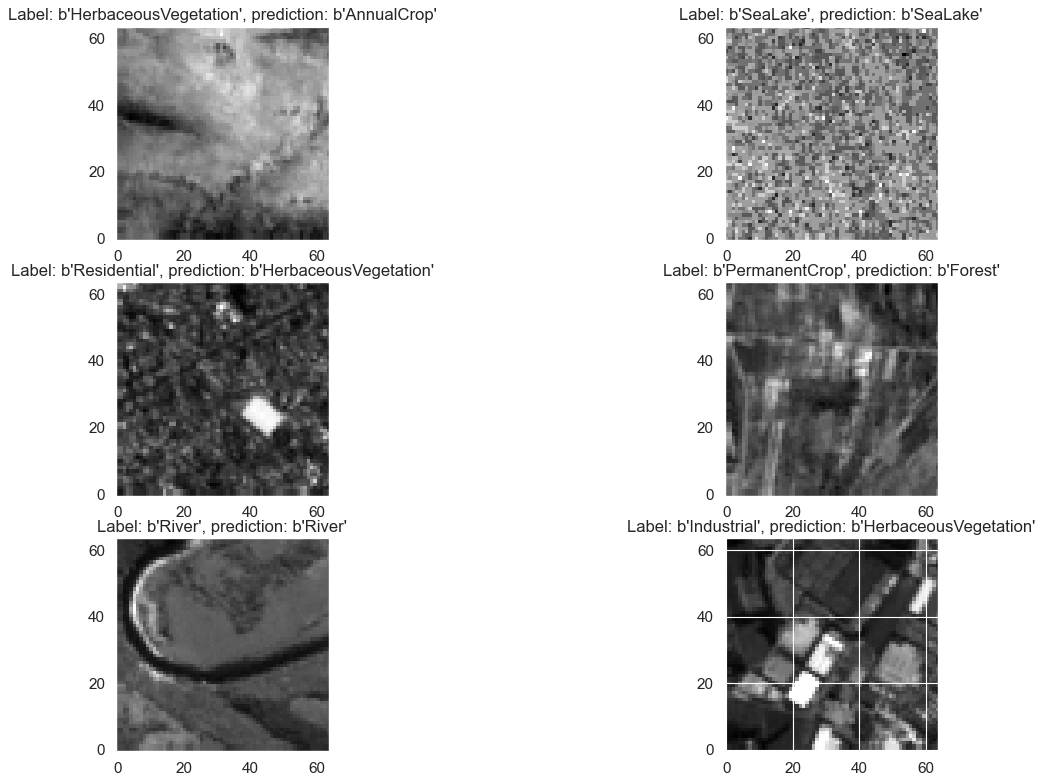

In [49]:
# Посмотрим на наши предсказания
plt.figure(figsize=[18,12])
for i in range(6):
    plt.grid(False)
    plt.subplot(3,2,i+1)
    plt.title("Label: "+str(label_names[y_test[i]])+", prediction: "+str(label_names[y_pred_standart_gs[i]])) 
    plt.imshow(X_test_gs[i].reshape([64,64]),cmap='gray');

#### Теперь обучим для цветных изображений

In [50]:
# инициализируем модель
clf = tree.DecisionTreeClassifier(random_state = 42)

# обучаем ее на тренировочных данных
clf = clf.fit(X_train_cl, y_train)

# делаем предсказание для тестовых данных
y_pred_standart_cl = clf.predict(X_test_cl)

print(metrics.accuracy_score(y_test, y_pred_standart_cl))
df_quality.loc["decision_tree_standart_cl", :] = quality_report(y_pred_standart_cl, y_test);
class_report(y_pred_standart_cl, y_test);

0.43320987654320986

=== Quality Report ===
Accuracy: 	 0.433
F1-Score: 	 0.422
Precision: 	 0.422
Recall: 	 0.424


              precision    recall  f1-score   support

           0      0.425     0.390     0.406      1964
           1      0.738     0.700     0.718      1897
           2      0.347     0.336     0.341      1855
           3      0.175     0.186     0.180      1405
           4      0.459     0.550     0.500      1250
           5      0.438     0.441     0.439      1191
           6      0.244     0.243     0.244      1504
           7      0.313     0.335     0.324      1679
           8      0.324     0.349     0.336      1394
           9      0.784     0.685     0.731      2061

    accuracy                          0.433     16200
   macro avg      0.424     0.422     0.422     16200
weighted avg      0.443     0.433     0.437     16200



In [51]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v02.pkl")
#(если надо сохранить)

In [52]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v02.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494


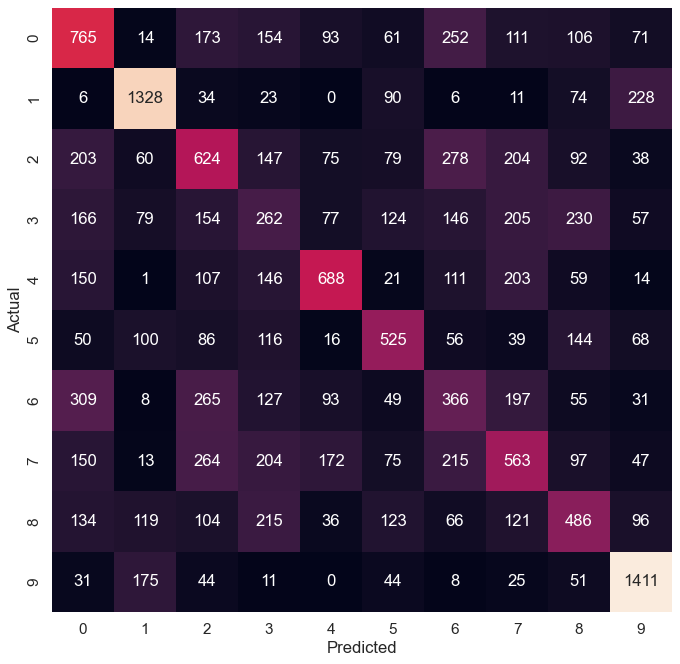

In [55]:
cm1 = pd.crosstab(y_test, y_pred_standart_cl, rownames=['Actual'], colnames=['Predicted'])
p1 = plt.figure(figsize=(10,10));
p1 = sb.heatmap(cm1, annot=True, fmt="d", cbar=False)

In [56]:
print(label_Dict)

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}


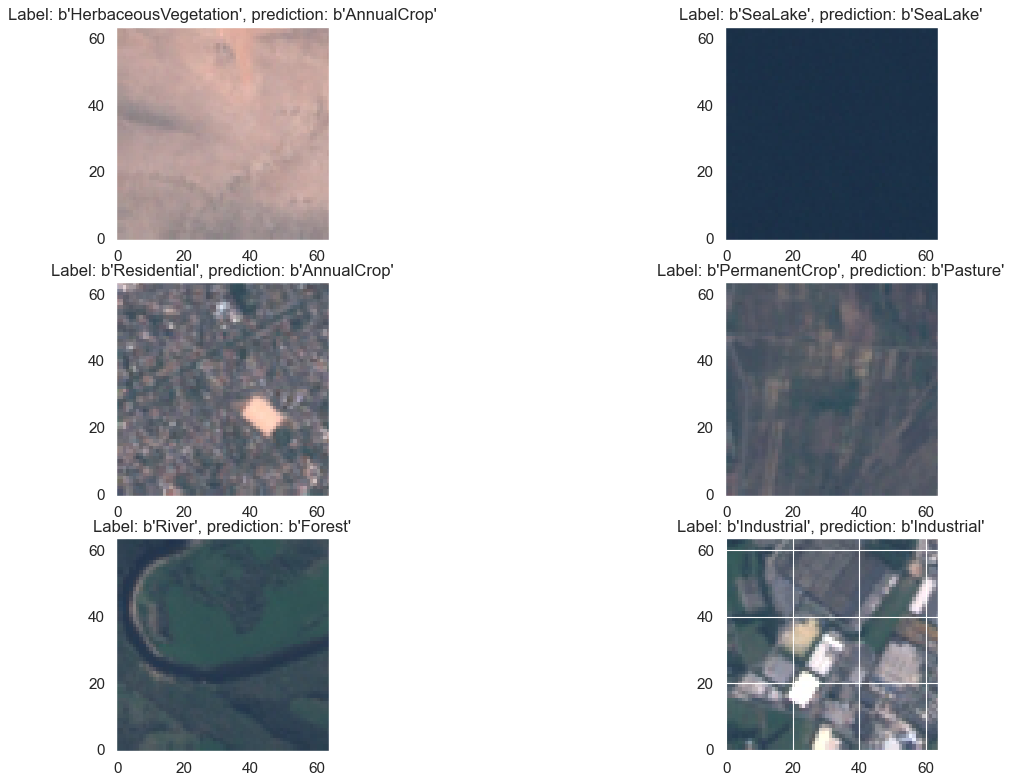

In [59]:
# Посмотрим на несколько картинок
fig=plt.figure(figsize=[18,12])
for i in range(6):
    plt.grid(False)
    plt.subplot(3,2,i+1)
    plt.title("Label: "+str(label_names[y_test[i]])+", prediction: "+str(label_names[y_pred_standart_cl[i]])) 
    plt.imshow(X_test[i].reshape([64,64,3]),cmap='gray');

#### Попытаемся найти лучшие параметры для нашего дерева

<function matplotlib.pyplot.show(close=None, block=None)>

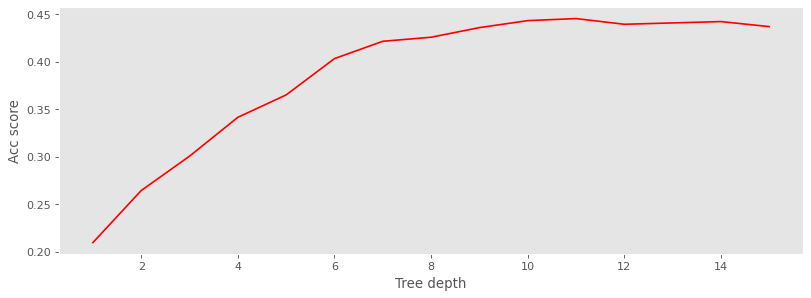

In [575]:
max_depths = np.linspace(1, 15, 15, endpoint=True)
results = []
for max_depth in max_depths:
    mdl = tree.DecisionTreeClassifier(max_depth=max_depth)
    mdl.fit(X_train_cl, y_train)
    test_pred = mdl.predict(X_test_cl)
    acc_s = metrics.accuracy_score(y_test, test_pred)
    results.append(acc_s)


plt.figure(figsize=[12,4])
plt.plot(max_depths, results, 'r', label='Test accuracy score')
plt.ylabel('Acc score')
plt.xlabel('Tree depth')
plt.show

Опытным путём было определено, что лучший max_depth = 11.Посчитаем с ним черно-белую модель:

In [60]:
# c 11 для Ч/Б
# инициализируем модель
clf = tree.DecisionTreeClassifier(max_depth=11, criterion='entropy', random_state=42)

# обучаем ее на тренировочных данных
clf = clf.fit(X_train_gs, y_train)

# делаем предсказание для тестовых данных
y_pred_tree_11_entr_gs = clf.predict(X_test_gs)

print(metrics.accuracy_score(y_test,y_pred_tree_11_entr_gs))
df_quality.loc["decision_tree_11_entr_gs", :] = quality_report(y_pred_tree_11_entr_gs, y_test);
class_report(y_pred_tree_11_entr_gs, y_test);

0.3639506172839506

=== Quality Report ===
Accuracy: 	 0.364
F1-Score: 	 0.348
Precision: 	 0.352
Recall: 	 0.357


              precision    recall  f1-score   support

           0      0.484     0.323     0.388      2693
           1      0.756     0.637     0.691      2134
           2      0.136     0.154     0.144      1585
           3      0.134     0.230     0.169       873
           4      0.352     0.476     0.405      1110
           5      0.412     0.286     0.338      1731
           6      0.166     0.198     0.181      1258
           7      0.293     0.271     0.281      1945
           8      0.277     0.368     0.316      1129
           9      0.558     0.577     0.567      1742

    accuracy                          0.364     16200
   macro avg      0.357     0.352     0.348     16200
weighted avg      0.396     0.364     0.373     16200



In [61]:
# c 11 для цветного изображения
# инициализируем модель
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)

# обучаем ее на тренировочных данных
clf = clf.fit(X_train_cl, y_train)

# делаем предсказание для тестовых данных
y_pred_tree_11_entr_cl = clf.predict(X_test_cl)

print(metrics.accuracy_score(y_test,y_pred_tree_11_entr_cl))
df_quality.loc["decision_tree_11_entr_cl", :] = quality_report(y_pred_tree_11_entr_cl, y_test);
class_report(y_pred_tree_11_entr_cl, y_test);

0.44160493827160496

=== Quality Report ===
Accuracy: 	 0.442
F1-Score: 	 0.430
Precision: 	 0.431
Recall: 	 0.433


              precision    recall  f1-score   support

           0      0.353     0.426     0.386      1489
           1      0.770     0.733     0.751      1890
           2      0.336     0.330     0.333      1833
           3      0.148     0.219     0.177      1015
           4      0.409     0.494     0.448      1243
           5      0.448     0.479     0.463      1122
           6      0.317     0.256     0.283      1859
           7      0.378     0.314     0.343      2169
           8      0.365     0.362     0.364      1513
           9      0.807     0.702     0.751      2067

    accuracy                          0.442     16200
   macro avg      0.433     0.431     0.430     16200
weighted avg      0.456     0.442     0.446     16200



C criterion='entropy' получается наилучший результат, поэтому оставим его.

<function matplotlib.pyplot.show(close=None, block=None)>

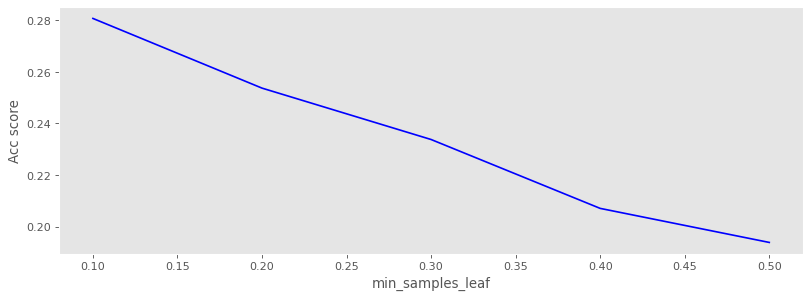

In [574]:
#Аналогично можно поиграться с min_samples_leaf

#min_leafs = np.linspace(0.1, 2, 20, endpoint=True) так не сработает
min_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
test_results = []
for min_spl in min_leafs:
    dt = tree.DecisionTreeClassifier(min_samples_leaf=min_spl, random_state=42, max_depth=11)
    dt.fit(X_train_cl, y_train)
    
    test_pred = dt.predict(X_test_cl)
    acc_s = metrics.accuracy_score(y_test, test_pred)
    test_results.append(acc_s)
    
    
plt.figure(figsize=[12,4])
plt.plot(min_leafs, test_results, 'b', label='Test min_samples_leaf')
plt.ylabel('Acc score')
plt.xlabel('min_samples_leaf')
plt.show

Похоже, тут лучше уже ничего не менять и переходить дальше.

Только сначала сохранимся

In [69]:
# Сохраним наш датафрейм c данными
#pd.DataFrame(df_quality).to_pickle("df_quality_v03.pkl")
#(если надо сохранить)

In [70]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v03.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028


#### Бэггинг - Попробуем ещё улучшить наш результат.

In [73]:
# Bagging with greyscale set
#!!! Be aware of high memory usage (about 13Gb) and 10 processor cores!!!
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)
bag_model=BaggingClassifier(base_estimator=clf, n_estimators=80, max_samples=1.0, bootstrap=True, n_jobs=10)
bag_model=bag_model.fit(X_train_gs, y_train)
y_pred_bag_gs = bag_model.predict(X_test_gs)

print(metrics.accuracy_score(y_test,y_pred_bag_gs))
df_quality.loc["bagg_tree_11_gs", :] = quality_report(y_pred_bag_gs, y_test);
class_report(y_pred_bag_gs, y_test);

0.49493827160493825

=== Quality Report ===
Accuracy: 	 0.495
F1-Score: 	 0.467
Precision: 	 0.484
Recall: 	 0.488


              precision    recall  f1-score   support

           0      0.667     0.418     0.514      2871
           1      0.895     0.648     0.752      2487
           2      0.133     0.256     0.175       935
           3      0.191     0.448     0.268       640
           4      0.709     0.667     0.687      1596
           5      0.499     0.417     0.454      1436
           6      0.163     0.301     0.211       810
           7      0.593     0.415     0.488      2574
           8      0.521     0.455     0.486      1719
           9      0.513     0.816     0.630      1132

    accuracy                          0.495     16200
   macro avg      0.488     0.484     0.467     16200
weighted avg      0.578     0.495     0.519     16200



Уже лучше, попробуем на цветном:

In [66]:
# Bagging with colored set
#!!! Be aware of high memory usage (about 13Gb) and 10 processor cores!!!
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)
bag_model=BaggingClassifier(base_estimator=clf, n_estimators=80, max_samples=1.0, bootstrap=True, n_jobs=10)
bag_model=bag_model.fit(X_train_cl, y_train)
y_pred_bag_cl = bag_model.predict(X_test_cl)

print(metrics.accuracy_score(y_test,y_pred_bag_cl))
df_quality.loc["bagg_tree_11_cl", :] = quality_report(y_pred_bag_cl, y_test);
class_report(y_pred_bag_cl, y_test);

0.6458641975308642

=== Quality Report ===
Accuracy: 	 0.646
F1-Score: 	 0.630
Precision: 	 0.638
Recall: 	 0.641


              precision    recall  f1-score   support

           0      0.674     0.628     0.650      1933
           1      0.893     0.789     0.838      2038
           2      0.463     0.575     0.513      1449
           3      0.230     0.532     0.321       649
           4      0.839     0.686     0.755      1833
           5      0.738     0.692     0.714      1279
           6      0.403     0.451     0.426      1338
           7      0.684     0.507     0.582      2431
           8      0.634     0.604     0.619      1575
           9      0.852     0.915     0.882      1675

    accuracy                          0.646     16200
   macro avg      0.641     0.638     0.630     16200
weighted avg      0.682     0.646     0.657     16200



Пока это успех (acc = 0.641; минимальный precision по классу = 0.233 ) 

In [74]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v04.pkl")
#(если надо сохранить)

In [75]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v04.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095


### Попробуем kNN

На Ч/Б:

In [78]:
# black & white:
knn = neighbors.KNeighborsClassifier(n_neighbors=3, n_jobs=3)
knn.fit(X_train_gs, y_train)
y_pred_knn_standart_gs = knn.predict(X_test_gs)

print(metrics.accuracy_score(y_test,y_pred_knn_standart_gs))
df_quality.loc["knn_standart_gs", :] = quality_report(y_pred_knn_standart_gs, y_test);
class_report(y_pred_knn_standart_gs, y_test);

0.20277777777777778

=== Quality Report ===
Accuracy: 	 0.203
F1-Score: 	 0.109
Precision: 	 0.306
Recall: 	 0.186


              precision    recall  f1-score   support

           0      0.609     0.258     0.363      4249
           1      0.007     0.037     0.012       352
           2      0.103     0.134     0.117      1391
           3      0.032     0.578     0.061        83
           4      0.001     1.000     0.001         1
           5      0.022     0.063     0.033       431
           6      0.004     0.133     0.008        45
           7      0.000     0.000     0.000         0
           8      0.104     0.675     0.180       231
           9      0.973     0.186     0.312      9417

    accuracy                          0.203     16200
   macro avg      0.186     0.306     0.109     16200
weighted avg      0.737     0.203     0.291     16200



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: 

На цветном изображении

In [79]:
# knn Coloured:
knn = neighbors.KNeighborsClassifier(n_neighbors=3, n_jobs=3)
knn.fit(X_train_cl, y_train)
y_pred_knn_standart_cl = knn.predict(X_test_cl)


print(metrics.accuracy_score(y_test,y_pred_knn_standart_cl))
df_quality.loc["knn_standart_cl", :] = quality_report(y_pred_knn_standart_cl, y_test);
class_report(y_pred_knn_standart_cl, y_test);

0.3379012345679012

=== Quality Report ===
Accuracy: 	 0.338
F1-Score: 	 0.252
Precision: 	 0.492
Recall: 	 0.316


              precision    recall  f1-score   support

           0      0.611     0.349     0.444      3152
           1      0.563     0.648     0.602      1564
           2      0.554     0.265     0.359      3762
           3      0.043     0.467     0.078       137
           4      0.004     1.000     0.008         6
           5      0.273     0.468     0.345       698
           6      0.023     0.304     0.042       112
           7      0.021     0.457     0.039        81
           8      0.101     0.691     0.177       220
           9      0.969     0.270     0.422      6468

    accuracy                          0.338     16200
   macro avg      0.316     0.492     0.252     16200
weighted avg      0.703     0.338     0.415     16200



#### Попробуем найти лучший k

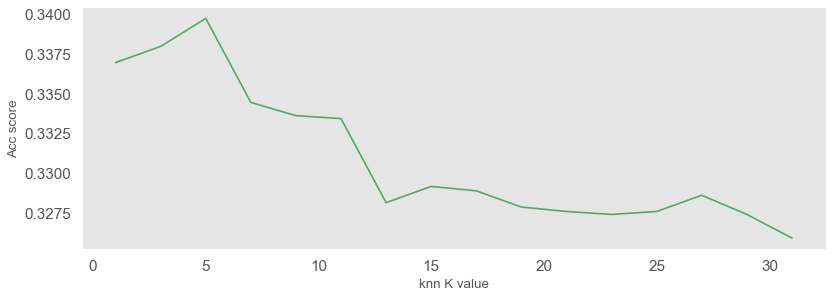

In [83]:
k_vars = list(range(1,32,2))
results = []
for k in k_vars:
    knn_search = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=3)
    scores = cross_val_score(knn_search, X_train_cl, y_train, cv=10, scoring='accuracy')
    results.append(scores.mean())
    
plt.figure(figsize=[12,4])
plt.plot(k_vars, results, 'g', label='Test knn best k')
plt.ylabel('Acc score')
plt.xlabel('knn K value')
plt.show()

In [84]:
# knn Coloured:
knn = neighbors.KNeighborsClassifier(n_neighbors=5, n_jobs=3)
knn.fit(X_train_cl, y_train)
y_pred_knn_k5_cl = knn.predict(X_test_cl)


print(metrics.accuracy_score(y_test,y_pred_knn_k5_cl))
df_quality.loc["knn_k5_cl", :] = quality_report(y_pred_knn_k5_cl, y_test);
class_report(y_pred_knn_k5_cl, y_test);

0.337037037037037

=== Quality Report ===
Accuracy: 	 0.337
F1-Score: 	 0.254
Precision: 	 0.482
Recall: 	 0.316


              precision    recall  f1-score   support

           0      0.563     0.378     0.452      2683
           1      0.572     0.683     0.623      1508
           2      0.564     0.263     0.359      3862
           3      0.031     0.452     0.059       104
           4      0.003     1.000     0.005         4
           5      0.302     0.446     0.360       811
           6      0.023     0.260     0.042       131
           7      0.016     0.354     0.031        82
           8      0.115     0.730     0.199       237
           9      0.974     0.259     0.409      6778

    accuracy                          0.337     16200
   macro avg      0.316     0.482     0.254     16200
weighted avg      0.706     0.337     0.411     16200



In [85]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v05.pkl")
#(если надо сохранить)

In [86]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v05.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095
knn_standart_gs,0.202778,0.108666,0.306438,0.185594
knn_standart_cl,0.337901,0.251574,0.491808,0.316039
knn_k5_cl,0.337037,0.253756,0.482348,0.316256


### Теперь попробуем CVM

Сначала на Ч/Б:

Нет, видимо не попробуем, т.к. с параметрами
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly']}
считается более 6 часов.

In [ ]:
param_grid={'C':[0.1,1],'gamma':[1],'kernel':['poly']}
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid, verbose=3, n_jobs=5)

model.fit(X_train_gs,y_train)

# Display parameters selected by GridSearchCV for SVM 3 classes
print("Best parameters to apply are:",model.best_params_)
# Display model after hyperparameter tuning
svm = model.best_estimator_
print("Model after tuning is:\n",svm)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [139]:
df_quality.head()

,ACC,F1,PRE,REC
bagging_tree_gs_11_entropy,0.430494,0.414993,0.417352,0.424789
bagging_10_tree_cl_11_entropy,0.641173,0.625718,0.633375,0.636117
bagging_80_tree_gs_11_entropy,0.495679,0.466101,0.483381,0.488906


### Попробуем применить Random Forest

In [87]:
# RandomForest with greyscale set

rfc = RandomForestClassifier(n_estimators=500, max_depth=20, n_jobs=8, random_state=42)
rfc.fit(X_train_gs, y_train)
y_pred_rf_500_20_gs = rfc.predict(X_test_gs)

print(metrics.accuracy_score(y_test,y_pred_rf_500_20_gs))
df_quality.loc["random_forest_500_20_gs", :] = quality_report(y_pred_rf_500_20_gs, y_test);
class_report(y_pred_rf_500_20_gs, y_test);

0.5651234567901234

=== Quality Report ===
Accuracy: 	 0.565
F1-Score: 	 0.539
Precision: 	 0.552
Recall: 	 0.556


              precision    recall  f1-score   support

           0      0.693     0.460     0.553      2711
           1      0.896     0.763     0.824      2113
           2      0.209     0.355     0.263      1062
           3      0.223     0.511     0.311       655
           4      0.819     0.730     0.772      1684
           5      0.503     0.490     0.497      1232
           6      0.217     0.360     0.270       903
           7      0.636     0.454     0.530      2520
           8      0.556     0.478     0.514      1744
           9      0.804     0.918     0.857      1576

    accuracy                          0.565     16200
   macro avg      0.556     0.552     0.539     16200
weighted avg      0.628     0.565     0.584     16200



In [88]:
# RandomForest with color set

rfc = RandomForestClassifier(n_estimators=500, max_depth=20, n_jobs=8, random_state=42)
rfc.fit(X_train_cl, y_train)
y_pred_rf_500_20_cl = rfc.predict(X_test_cl)

print(metrics.accuracy_score(y_test,y_pred_rf_500_20_cl))
df_quality.loc["random_forest_500_20_cl", :] = quality_report(y_pred_rf_500_20_cl, y_test);
class_report(y_pred_rf_500_20_cl, y_test);

0.669320987654321

=== Quality Report ===
Accuracy: 	 0.669
F1-Score: 	 0.653
Precision: 	 0.659
Recall: 	 0.664


              precision    recall  f1-score   support

           0      0.696     0.624     0.658      2007
           1      0.905     0.814     0.857      2001
           2      0.523     0.626     0.570      1503
           3      0.245     0.537     0.336       683
           4      0.877     0.727     0.795      1810
           5      0.759     0.698     0.727      1306
           6      0.406     0.492     0.445      1237
           7      0.692     0.530     0.600      2352
           8      0.646     0.616     0.631      1573
           9      0.891     0.928     0.909      1728

    accuracy                          0.669     16200
   macro avg      0.664     0.659     0.653     16200
weighted avg      0.705     0.669     0.681     16200



In [89]:
# Сохраним наш датафрейм c данными
#pd.DataFrame(df_quality).to_pickle("df_quality_v06.pkl")
#(если надо сохранить)

In [90]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v06.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095
knn_standart_gs,0.202778,0.108666,0.306438,0.185594
knn_standart_cl,0.337901,0.251574,0.491808,0.316039
knn_k5_cl,0.337037,0.253756,0.482348,0.316256
random_forest_500_20_gs,0.565123,0.539182,0.551999,0.555644


Попробуем посмотреть на max_depth

<function matplotlib.pyplot.show(close=None, block=None)>

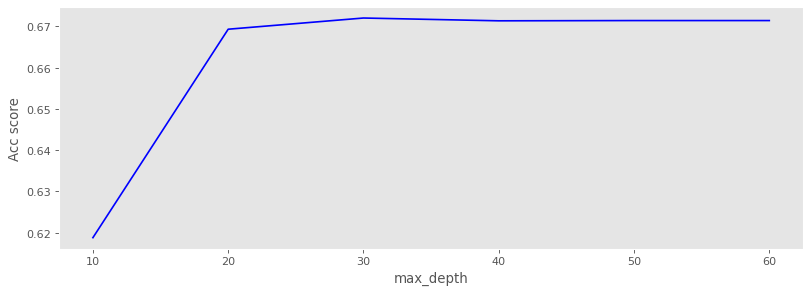

In [173]:
#Попробуем посмотреть на max_depth для RandomForest

max_depth = np.linspace(10, 60, 6, endpoint=True)
results = []
for md in max_depth:
    rf = RandomForestClassifier(n_estimators=500, max_depth=md, n_jobs=8, random_state=42)
    rf.fit(X_train_cl, y_train)
    test_pred = rf.predict(X_test_cl)
    acc_s = metrics.accuracy_score(y_test, test_pred)
    results.append(acc_s)
    
    
plt.figure(figsize=[12,4])
plt.plot(max_depth, results, 'b', label='Test RF with max_depth')
plt.ylabel('Acc score')
plt.xlabel('max_depth')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

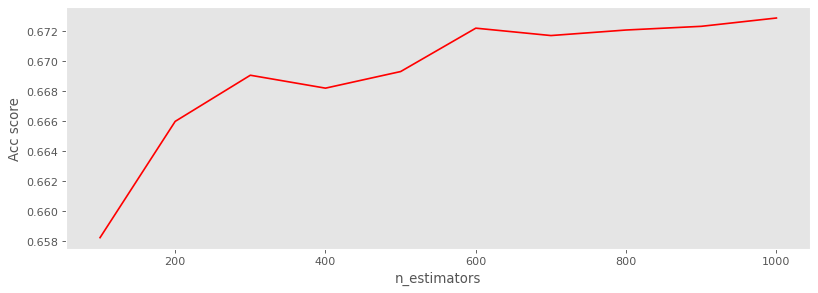

In [180]:
#Попробуем посмотреть на n_estimators для RandomForest

estimators = np.linspace(100, 1000, 10, endpoint=True).astype(int)
results = []
for esti in estimators:
    rf = RandomForestClassifier(n_estimators=esti, max_depth=20, n_jobs=8, random_state=42)
    rf.fit(X_train_cl, y_train)
    test_pred = rf.predict(X_test_cl)
    acc_s = metrics.accuracy_score(y_test, test_pred)
    results.append(acc_s)
    
    
plt.figure(figsize=[12,4])
plt.plot(estimators, results, 'r', label='Test RF with n_estimators')
plt.ylabel('Acc score')
plt.xlabel('n_estimators')
plt.show

Попробуем рассчитать для значения 600

In [91]:
# RandomForest with color set with n_estimators=500

rfc = RandomForestClassifier(n_estimators=600, max_depth=20, n_jobs=8, random_state=42)
rfc.fit(X_train_cl, y_train)
y_pred_rf_600_20_cl = rfc.predict(X_test_cl)

print(metrics.accuracy_score(y_test,y_pred_rf_600_20_cl))
df_quality.loc["random_forest_600_20_cl", :] = quality_report(y_pred_rf_600_20_cl, y_test);
class_report(y_pred_rf_600_20_cl, y_test);

0.6722222222222223

=== Quality Report ===
Accuracy: 	 0.672
F1-Score: 	 0.656
Precision: 	 0.662
Recall: 	 0.667


              precision    recall  f1-score   support

           0      0.703     0.628     0.664      2013
           1      0.908     0.815     0.859      2004
           2      0.527     0.635     0.576      1494
           3      0.256     0.549     0.349       700
           4      0.879     0.727     0.796      1813
           5      0.758     0.698     0.727      1304
           6      0.401     0.486     0.440      1239
           7      0.693     0.534     0.604      2335
           8      0.651     0.622     0.636      1571
           9      0.891     0.929     0.910      1727

    accuracy                          0.672     16200
   macro avg      0.667     0.662     0.656     16200
weighted avg      0.707     0.672     0.684     16200



acc = 0.67 Пока это рекорд. Но точно ли всё так хорошо?

In [92]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v07.pkl")
#(если надо сохранить)

In [93]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v07.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095
knn_standart_gs,0.202778,0.108666,0.306438,0.185594
knn_standart_cl,0.337901,0.251574,0.491808,0.316039
knn_k5_cl,0.337037,0.253756,0.482348,0.316256
random_forest_500_20_gs,0.565123,0.539182,0.551999,0.555644


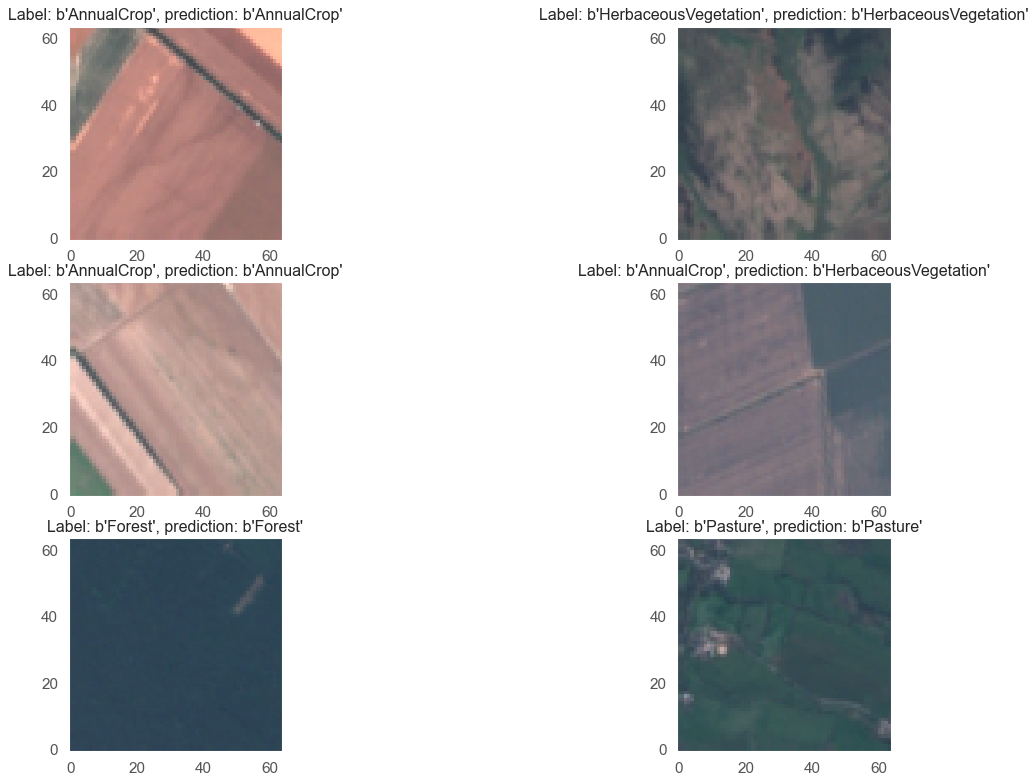

In [94]:
# Посмотрим на несколько картинок
plt.figure(figsize=[18,12])
j = 0
for i in range(11100, 11106):
    plt.subplot(3,2,j+1)
    plt.title("Label: "+str(label_names[y_test[i]])+", prediction: "+str(label_names[y_pred_rf_600_20_cl[i]])) 
    plt.imshow(X_test[i].reshape([64,64,3]),cmap='gray');
    j = j+1

In [95]:
pprint.pprint(label_Dict)

{0: b'AnnualCrop',
 1: b'Forest',
 2: b'HerbaceousVegetation',
 3: b'Highway',
 4: b'Industrial',
 5: b'Pasture',
 6: b'PermanentCrop',
 7: b'Residential',
 8: b'River',
 9: b'SeaLake'}


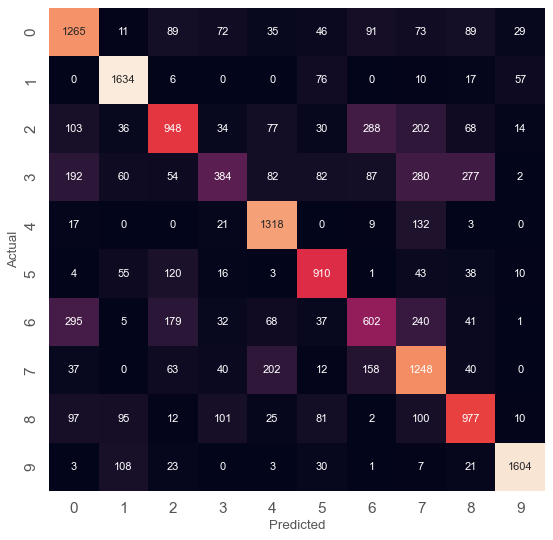

In [102]:
cm2 = pd.crosstab(y_test, y_pred_rf_600_20_cl, rownames=['Actual'], colnames=['Predicted'])
p2 = plt.figure(figsize=(8,8));
p2 = sb.heatmap(cm2, annot=True, fmt="d", cbar=False)
plt.show()

#### Попробуем сделать GridSearch для RandomForest

In [219]:
# RandomForest with color set with n_estimators=500 and entropy
params = {'n_estimators': [300, 600], 'max_features': [None, 3], 'max_depth': [20]}

rfc = RandomForestClassifier(random_state=42)
gcv = GridSearchCV(rfc, params, scoring = 'accuracy')
gcv.fit(X_train_cl, y_train)
y_pred_rf_gcv = gcv.predict(X_test_cl)

print('Best params: ', gcv.best_params_)

KeyboardInterrupt: 

In [103]:
df_quality

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095
knn_standart_gs,0.202778,0.108666,0.306438,0.185594
knn_standart_cl,0.337901,0.251574,0.491808,0.316039
knn_k5_cl,0.337037,0.253756,0.482348,0.316256
random_forest_500_20_gs,0.565123,0.539182,0.551999,0.555644


#### CatBoost

In [104]:
#CatBoost GreyScale
from catboost import CatBoostClassifier

cat = CatBoostClassifier(loss_function='MultiClass', task_type='GPU', random_state=42 )
cat.fit(X_train_gs, y_train)
y_pred_cat_gs = cat.predict(X_test_gs)

print(metrics.accuracy_score(y_test, y_pred_cat_gs))
ql_cat_gs = quality_report(y_pred_cat_gs, y_test);
df_quality.loc["cat_boost_gs", :] = ql_cat_gs
class_report(y_pred_cat_gs, y_test);

Learning rate set to 0.105463
0:	learn: 2.1941732	total: 297ms	remaining: 4m 56s
1:	learn: 2.1210265	total: 572ms	remaining: 4m 45s
2:	learn: 2.0629239	total: 838ms	remaining: 4m 38s
3:	learn: 2.0152116	total: 1.1s	remaining: 4m 34s
4:	learn: 1.9729293	total: 1.37s	remaining: 4m 32s
5:	learn: 1.9345056	total: 1.66s	remaining: 4m 35s
6:	learn: 1.9006028	total: 1.96s	remaining: 4m 37s
7:	learn: 1.8700235	total: 2.24s	remaining: 4m 38s
8:	learn: 1.8461207	total: 2.48s	remaining: 4m 33s
9:	learn: 1.8220707	total: 2.74s	remaining: 4m 31s
10:	learn: 1.7991158	total: 3s	remaining: 4m 29s
11:	learn: 1.7807248	total: 3.24s	remaining: 4m 26s
12:	learn: 1.7644671	total: 3.48s	remaining: 4m 24s
13:	learn: 1.7484670	total: 3.72s	remaining: 4m 22s
14:	learn: 1.7336455	total: 3.96s	remaining: 4m 20s
15:	learn: 1.7210187	total: 4.24s	remaining: 4m 20s
16:	learn: 1.7100611	total: 4.45s	remaining: 4m 17s
17:	learn: 1.7012147	total: 4.72s	remaining: 4m 17s
18:	learn: 1.6906892	total: 4.98s	remaining: 4m 

158:	learn: 1.1549348	total: 40.9s	remaining: 3m 36s
159:	learn: 1.1534880	total: 41.1s	remaining: 3m 36s
160:	learn: 1.1512951	total: 41.4s	remaining: 3m 35s
161:	learn: 1.1501005	total: 41.7s	remaining: 3m 35s
162:	learn: 1.1481235	total: 41.9s	remaining: 3m 35s
163:	learn: 1.1445238	total: 42.2s	remaining: 3m 35s
164:	learn: 1.1432166	total: 42.5s	remaining: 3m 34s
165:	learn: 1.1410091	total: 42.7s	remaining: 3m 34s
166:	learn: 1.1384512	total: 43s	remaining: 3m 34s
167:	learn: 1.1358738	total: 43.3s	remaining: 3m 34s
168:	learn: 1.1339321	total: 43.5s	remaining: 3m 34s
169:	learn: 1.1294216	total: 43.8s	remaining: 3m 33s
170:	learn: 1.1282739	total: 44.1s	remaining: 3m 33s
171:	learn: 1.1248925	total: 44.3s	remaining: 3m 33s
172:	learn: 1.1226638	total: 44.6s	remaining: 3m 33s
173:	learn: 1.1200355	total: 44.9s	remaining: 3m 32s
174:	learn: 1.1169224	total: 45.1s	remaining: 3m 32s
175:	learn: 1.1142961	total: 45.4s	remaining: 3m 32s
176:	learn: 1.1104206	total: 45.7s	remaining: 3m

313:	learn: 0.8212588	total: 1m 22s	remaining: 3m
314:	learn: 0.8206596	total: 1m 23s	remaining: 3m
315:	learn: 0.8190675	total: 1m 23s	remaining: 3m
316:	learn: 0.8179121	total: 1m 23s	remaining: 3m
317:	learn: 0.8161902	total: 1m 23s	remaining: 2m 59s
318:	learn: 0.8131498	total: 1m 24s	remaining: 2m 59s
319:	learn: 0.8103117	total: 1m 24s	remaining: 2m 59s
320:	learn: 0.8094006	total: 1m 24s	remaining: 2m 59s
321:	learn: 0.8070300	total: 1m 25s	remaining: 2m 58s
322:	learn: 0.8060635	total: 1m 25s	remaining: 2m 58s
323:	learn: 0.8043924	total: 1m 25s	remaining: 2m 58s
324:	learn: 0.8023307	total: 1m 25s	remaining: 2m 58s
325:	learn: 0.8003353	total: 1m 26s	remaining: 2m 58s
326:	learn: 0.7991667	total: 1m 26s	remaining: 2m 57s
327:	learn: 0.7982253	total: 1m 26s	remaining: 2m 57s
328:	learn: 0.7959904	total: 1m 26s	remaining: 2m 57s
329:	learn: 0.7934405	total: 1m 27s	remaining: 2m 57s
330:	learn: 0.7916271	total: 1m 27s	remaining: 2m 56s
331:	learn: 0.7900409	total: 1m 27s	remainin

466:	learn: 0.6005578	total: 2m 5s	remaining: 2m 22s
467:	learn: 0.6001109	total: 2m 5s	remaining: 2m 22s
468:	learn: 0.5983869	total: 2m 5s	remaining: 2m 22s
469:	learn: 0.5968808	total: 2m 5s	remaining: 2m 21s
470:	learn: 0.5954591	total: 2m 6s	remaining: 2m 21s
471:	learn: 0.5941021	total: 2m 6s	remaining: 2m 21s
472:	learn: 0.5934528	total: 2m 6s	remaining: 2m 21s
473:	learn: 0.5930198	total: 2m 6s	remaining: 2m 20s
474:	learn: 0.5919138	total: 2m 7s	remaining: 2m 20s
475:	learn: 0.5905928	total: 2m 7s	remaining: 2m 20s
476:	learn: 0.5898481	total: 2m 7s	remaining: 2m 20s
477:	learn: 0.5883022	total: 2m 7s	remaining: 2m 19s
478:	learn: 0.5867396	total: 2m 8s	remaining: 2m 19s
479:	learn: 0.5850856	total: 2m 8s	remaining: 2m 19s
480:	learn: 0.5836166	total: 2m 8s	remaining: 2m 19s
481:	learn: 0.5824802	total: 2m 9s	remaining: 2m 18s
482:	learn: 0.5808673	total: 2m 9s	remaining: 2m 18s
483:	learn: 0.5796526	total: 2m 9s	remaining: 2m 18s
484:	learn: 0.5790422	total: 2m 9s	remaining: 

619:	learn: 0.4455244	total: 2m 47s	remaining: 1m 42s
620:	learn: 0.4442488	total: 2m 47s	remaining: 1m 42s
621:	learn: 0.4433575	total: 2m 47s	remaining: 1m 41s
622:	learn: 0.4420279	total: 2m 48s	remaining: 1m 41s
623:	learn: 0.4409969	total: 2m 48s	remaining: 1m 41s
624:	learn: 0.4402126	total: 2m 48s	remaining: 1m 41s
625:	learn: 0.4394413	total: 2m 48s	remaining: 1m 40s
626:	learn: 0.4389261	total: 2m 49s	remaining: 1m 40s
627:	learn: 0.4381474	total: 2m 49s	remaining: 1m 40s
628:	learn: 0.4374685	total: 2m 49s	remaining: 1m 40s
629:	learn: 0.4364481	total: 2m 50s	remaining: 1m 39s
630:	learn: 0.4354182	total: 2m 50s	remaining: 1m 39s
631:	learn: 0.4352241	total: 2m 50s	remaining: 1m 39s
632:	learn: 0.4340157	total: 2m 50s	remaining: 1m 39s
633:	learn: 0.4333872	total: 2m 51s	remaining: 1m 38s
634:	learn: 0.4319940	total: 2m 51s	remaining: 1m 38s
635:	learn: 0.4314094	total: 2m 51s	remaining: 1m 38s
636:	learn: 0.4304848	total: 2m 52s	remaining: 1m 38s
637:	learn: 0.4295685	total:

773:	learn: 0.3381675	total: 3m 30s	remaining: 1m 1s
774:	learn: 0.3375019	total: 3m 30s	remaining: 1m 1s
775:	learn: 0.3370537	total: 3m 30s	remaining: 1m
776:	learn: 0.3365436	total: 3m 31s	remaining: 1m
777:	learn: 0.3363576	total: 3m 31s	remaining: 1m
778:	learn: 0.3361451	total: 3m 31s	remaining: 1m
779:	learn: 0.3357430	total: 3m 31s	remaining: 59.8s
780:	learn: 0.3349103	total: 3m 32s	remaining: 59.5s
781:	learn: 0.3348126	total: 3m 32s	remaining: 59.2s
782:	learn: 0.3342054	total: 3m 32s	remaining: 58.9s
783:	learn: 0.3335194	total: 3m 32s	remaining: 58.7s
784:	learn: 0.3333199	total: 3m 33s	remaining: 58.4s
785:	learn: 0.3331514	total: 3m 33s	remaining: 58.1s
786:	learn: 0.3329904	total: 3m 33s	remaining: 57.8s
787:	learn: 0.3322124	total: 3m 33s	remaining: 57.6s
788:	learn: 0.3318334	total: 3m 34s	remaining: 57.3s
789:	learn: 0.3311292	total: 3m 34s	remaining: 57s
790:	learn: 0.3308150	total: 3m 34s	remaining: 56.8s
791:	learn: 0.3305518	total: 3m 35s	remaining: 56.5s
792:	le

930:	learn: 0.2625041	total: 4m 14s	remaining: 18.8s
931:	learn: 0.2623088	total: 4m 14s	remaining: 18.6s
932:	learn: 0.2619410	total: 4m 14s	remaining: 18.3s
933:	learn: 0.2618172	total: 4m 14s	remaining: 18s
934:	learn: 0.2611824	total: 4m 15s	remaining: 17.7s
935:	learn: 0.2608464	total: 4m 15s	remaining: 17.5s
936:	learn: 0.2601083	total: 4m 15s	remaining: 17.2s
937:	learn: 0.2599634	total: 4m 15s	remaining: 16.9s
938:	learn: 0.2593913	total: 4m 16s	remaining: 16.6s
939:	learn: 0.2587219	total: 4m 16s	remaining: 16.4s
940:	learn: 0.2582003	total: 4m 16s	remaining: 16.1s
941:	learn: 0.2575313	total: 4m 17s	remaining: 15.8s
942:	learn: 0.2568962	total: 4m 17s	remaining: 15.6s
943:	learn: 0.2564058	total: 4m 17s	remaining: 15.3s
944:	learn: 0.2562444	total: 4m 18s	remaining: 15s
945:	learn: 0.2560261	total: 4m 18s	remaining: 14.7s
946:	learn: 0.2554442	total: 4m 18s	remaining: 14.5s
947:	learn: 0.2548474	total: 4m 18s	remaining: 14.2s
948:	learn: 0.2543660	total: 4m 19s	remaining: 13.

In [105]:
print(metrics.accuracy_score(y_test, y_pred_cat_gs))
ql_cat_gs = quality_report(y_pred_cat_gs, y_test);
df_quality.loc["cat_boost_gs", :] = ql_cat_gs
class_report(y_pred_cat_gs, y_test);

0.6345679012345679

=== Quality Report ===
Accuracy: 	 0.635
F1-Score: 	 0.622
Precision: 	 0.622
Recall: 	 0.626


              precision    recall  f1-score   support

           0      0.726     0.637     0.679      2052
           1      0.887     0.812     0.848      1965
           2      0.334     0.358     0.346      1677
           3      0.381     0.488     0.428      1170
           4      0.807     0.812     0.809      1491
           5      0.566     0.504     0.533      1347
           6      0.411     0.424     0.417      1456
           7      0.766     0.733     0.749      1881
           8      0.552     0.545     0.548      1520
           9      0.829     0.910     0.868      1641

    accuracy                          0.635     16200
   macro avg      0.626     0.622     0.622     16200
weighted avg      0.645     0.635     0.638     16200



In [106]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v08.pkl")
#(если надо сохранить)

In [107]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v08.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095
knn_standart_gs,0.202778,0.108666,0.306438,0.185594
knn_standart_cl,0.337901,0.251574,0.491808,0.316039
knn_k5_cl,0.337037,0.253756,0.482348,0.316256
random_forest_500_20_gs,0.565123,0.539182,0.551999,0.555644


### А теперь то же самое для цветных изображений

In [108]:
#CatBoost Colored
from catboost import CatBoostClassifier

# Почему-то python перезагружается, если пытаться рассчитать это на CUDA (хотя ч/б работает)

cat = CatBoostClassifier(iterations=200, max_depth=3, loss_function='MultiClass', task_type='GPU', random_state=42 )
cat.fit(X_train_cl, y_train)
y_pred_cat_cl = cat.predict(X_test_cl)

print(metrics.accuracy_score(y_test, y_pred_cat_cl))
ql_cat_cl = quality_report(y_pred_cat_cl, y_test);
df_quality.loc["cat_boost_cl", :] = ql_cat_cl
class_report(y_pred_cat_cl, y_test);

Learning rate set to 0.403036
0:	learn: 2.0390383	total: 419ms	remaining: 1m 23s
1:	learn: 1.9246139	total: 565ms	remaining: 56s
2:	learn: 1.8454720	total: 705ms	remaining: 46.3s
3:	learn: 1.7834701	total: 846ms	remaining: 41.4s
4:	learn: 1.7495727	total: 977ms	remaining: 38.1s
5:	learn: 1.7022472	total: 1.11s	remaining: 35.8s
6:	learn: 1.6722810	total: 1.24s	remaining: 34.1s
7:	learn: 1.6539690	total: 1.37s	remaining: 32.9s
8:	learn: 1.6288627	total: 1.51s	remaining: 32.1s
9:	learn: 1.6063985	total: 1.64s	remaining: 31.2s
10:	learn: 1.5926895	total: 1.77s	remaining: 30.4s
11:	learn: 1.5552532	total: 1.91s	remaining: 30s
12:	learn: 1.5409429	total: 2.04s	remaining: 29.4s
13:	learn: 1.5170826	total: 2.17s	remaining: 28.9s
14:	learn: 1.5033488	total: 2.3s	remaining: 28.3s
15:	learn: 1.4943977	total: 2.42s	remaining: 27.8s
16:	learn: 1.4810418	total: 2.55s	remaining: 27.5s
17:	learn: 1.4734403	total: 2.68s	remaining: 27.1s
18:	learn: 1.4583650	total: 2.81s	remaining: 26.8s
19:	learn: 1.45

162:	learn: 0.6914498	total: 22.8s	remaining: 5.17s
163:	learn: 0.6866622	total: 23s	remaining: 5.04s
164:	learn: 0.6857889	total: 23.1s	remaining: 4.9s
165:	learn: 0.6849390	total: 23.2s	remaining: 4.75s
166:	learn: 0.6829642	total: 23.3s	remaining: 4.61s
167:	learn: 0.6808428	total: 23.5s	remaining: 4.47s
168:	learn: 0.6784914	total: 23.6s	remaining: 4.33s
169:	learn: 0.6753536	total: 23.8s	remaining: 4.19s
170:	learn: 0.6726172	total: 23.9s	remaining: 4.05s
171:	learn: 0.6716624	total: 24s	remaining: 3.91s
172:	learn: 0.6698697	total: 24.1s	remaining: 3.77s
173:	learn: 0.6685005	total: 24.3s	remaining: 3.63s
174:	learn: 0.6651344	total: 24.4s	remaining: 3.49s
175:	learn: 0.6632343	total: 24.6s	remaining: 3.35s
176:	learn: 0.6614805	total: 24.7s	remaining: 3.21s
177:	learn: 0.6589617	total: 24.8s	remaining: 3.07s
178:	learn: 0.6578772	total: 25s	remaining: 2.93s
179:	learn: 0.6567354	total: 25.1s	remaining: 2.79s
180:	learn: 0.6527637	total: 25.3s	remaining: 2.65s
181:	learn: 0.65166

In [109]:
print(metrics.accuracy_score(y_test, y_pred_cat_cl))
ql_cat_cl = quality_report(y_pred_cat_cl, y_test);
df_quality.loc["cat_boost_cl", :] = ql_cat_cl
class_report(y_pred_cat_cl, y_test);

0.6605555555555556

=== Quality Report ===
Accuracy: 	 0.661
F1-Score: 	 0.653
Precision: 	 0.653
Recall: 	 0.655


              precision    recall  f1-score   support

           0      0.681     0.678     0.679      1806
           1      0.851     0.788     0.818      1944
           2      0.562     0.557     0.559      1814
           3      0.375     0.506     0.431      1110
           4      0.789     0.834     0.811      1419
           5      0.728     0.653     0.688      1337
           6      0.467     0.478     0.472      1464
           7      0.703     0.606     0.651      2089
           8      0.574     0.611     0.592      1409
           9      0.827     0.823     0.825      1808

    accuracy                          0.661     16200
   macro avg      0.655     0.653     0.653     16200
weighted avg      0.671     0.661     0.664     16200



In [110]:
# Сохраним наш датафрейм c данными
pd.DataFrame(df_quality).to_pickle("df_quality_v10.pkl")
#(если надо сохранить)



In [111]:
# Загрузка отчета из сейва
df_quality_new = pd.read_pickle("df_quality_v10.pkl")
df_quality_new

,ACC,F1,PRE,REC
decision_tree_standart_gs,0.35463,0.343445,0.345034,0.344811
decision_tree_standart_cl,0.43321,0.422034,0.421556,0.424494
decision_tree_11_entr_gs,0.363951,0.348101,0.352083,0.356794
decision_tree_11_entr_cl,0.441605,0.429742,0.431483,0.433028
bagg_tree_11_gs,0.494938,0.466594,0.484091,0.488494
bagg_tree_11_cl,0.645864,0.629994,0.637901,0.64095
knn_standart_gs,0.202778,0.108666,0.306438,0.185594
knn_standart_cl,0.337901,0.251574,0.491808,0.316039
knn_k5_cl,0.337037,0.253756,0.482348,0.316256
random_forest_500_20_gs,0.565123,0.539182,0.551999,0.555644


Попробуем ещё раз без параметров

In [ ]:
#CatBoost Colored No Params
from catboost import CatBoostClassifier

# Почему-то python перезагружается, если пытаться рассчитать это на CUDA (хотя ч/б работает)

cat = CatBoostClassifier(loss_function='MultiClass', task_type='GPU', random_state=42 )
cat.fit(X_train_cl, y_train)
y_pred_cat_cl_no_p = cat.predict(X_test_cl)

print(metrics.accuracy_score(y_test, y_pred_cat_cl_no_p))
ql_cat_cl_no_p = quality_report(y_pred_cat_cl_no_p, y_test);
df_quality.loc["cat_boost_cl_no_params", :] = ql_cat_cl_no_p
class_report(y_pred_cat_cl_no_p, y_test);

Learning rate set to 0.105463


И всё-таки он уходит в reboot....

In [212]:
## End ##of## ML #####

In [213]:
####### NN ################

## NN

In [86]:
batch_size = 24
#classes = 10
epochs = 10
#img_rows, img_columns = 64, 64
#img_channel = 3
#filters = 32
#pool = 2
#conv = 3

In [87]:
# yLabels and io_img are arrays
x_nn = np.array(raw_images) #floats
y_nn = np.array(yLabels)

In [88]:
x_nn[1][1,1]

array([0.21568627, 0.38039216, 0.3254902 ])

In [89]:
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(x_nn, y_nn, test_size = 0.4, random_state = 42)

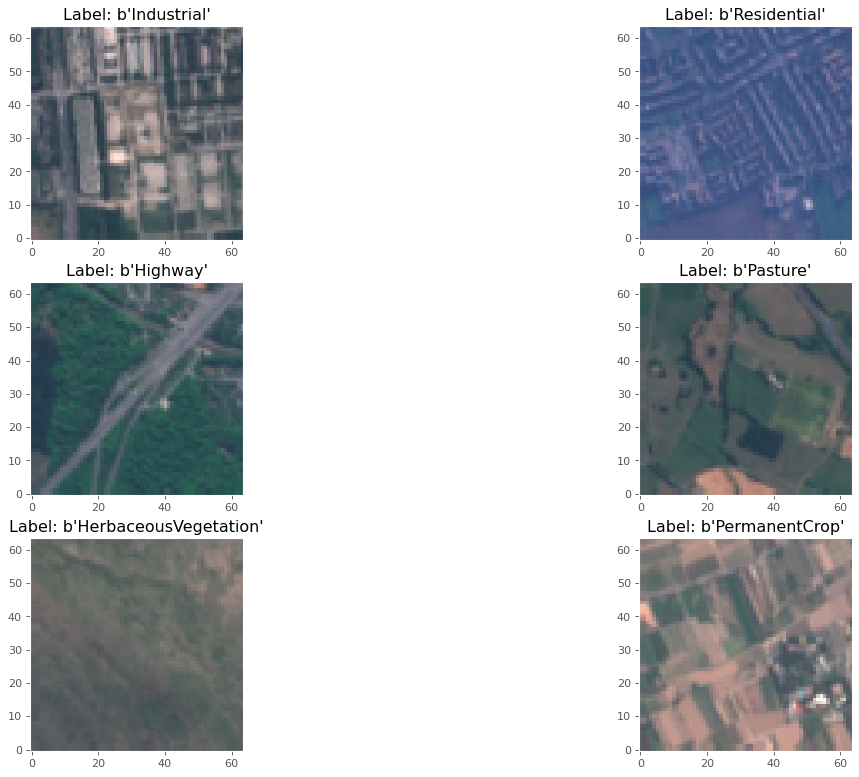

In [90]:
# Проверяем, что лейблы и данные соответствуют друг другу
plt.figure(figsize=[18,12])
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.title("Label: "+str(label_names[y_train[i]])) 
    plt.imshow(X_train[i], cmap='gray');

In [91]:
nnm = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(64, 64, 3)), # our image size
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax) #10 - classes
])

In [92]:
nnm.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [93]:
nnm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 8192)             

In [94]:
nnm.fit(X_train_nn, y_train_nn, batch_size = batch_size, epochs = epochs, verbose = 1, validation_data = (X_test_nn, y_test_nn))

Epoch 1/10
675/675 [==============================] - 44s 64ms/step - loss: 1.3278 - accuracy: 0.5025 - val_loss: 0.9146 - val_accuracy: 0.6869
Epoch 2/10
675/675 [==============================] - 43s 63ms/step - loss: 0.9183 - accuracy: 0.6652 - val_loss: 0.9101 - val_accuracy: 0.6707
Epoch 3/10
675/675 [==============================] - 43s 64ms/step - loss: 0.7595 - accuracy: 0.7293 - val_loss: 0.7279 - val_accuracy: 0.7325
Epoch 4/10
675/675 [==============================] - 43s 63ms/step - loss: 0.6555 - accuracy: 0.7633 - val_loss: 0.7368 - val_accuracy: 0.7315
Epoch 5/10
675/675 [==============================] - 43s 64ms/step - loss: 0.5875 - accuracy: 0.7883 - val_loss: 0.6407 - val_accuracy: 0.7728
Epoch 6/10
675/675 [==============================] - 43s 64ms/step - loss: 0.5365 - accuracy: 0.8041 - val_loss: 0.6941 - val_accuracy: 0.7527
Epoch 7/10
675/675 [==============================] - 44s 66ms/step - loss: 0.4936 - accuracy: 0.8199 - val_loss: 0.7396 - val_accuracy:

In [95]:
score = nnm.evaluate(X_test_nn, y_test_nn, verbose = 0 )

In [96]:
score

[0.5541285276412964, 0.804722249507904]

In [97]:
print('Accuracy :', score[1])

Accuracy : 0.804722249507904


In [100]:
y_pred_nn = nnm.predict(X_test_nn)

338/338 [==============================] - 5s 16ms/step


In [106]:
y_pred_nn[1]

array([5.9661118e-04, 3.7829476e-11, 4.1317320e-03, 7.2564244e-01,
       1.3486376e-04, 2.6429316e-07, 2.6913351e-01, 4.5426600e-07,
       3.6019413e-04, 2.0055123e-12], dtype=float32)

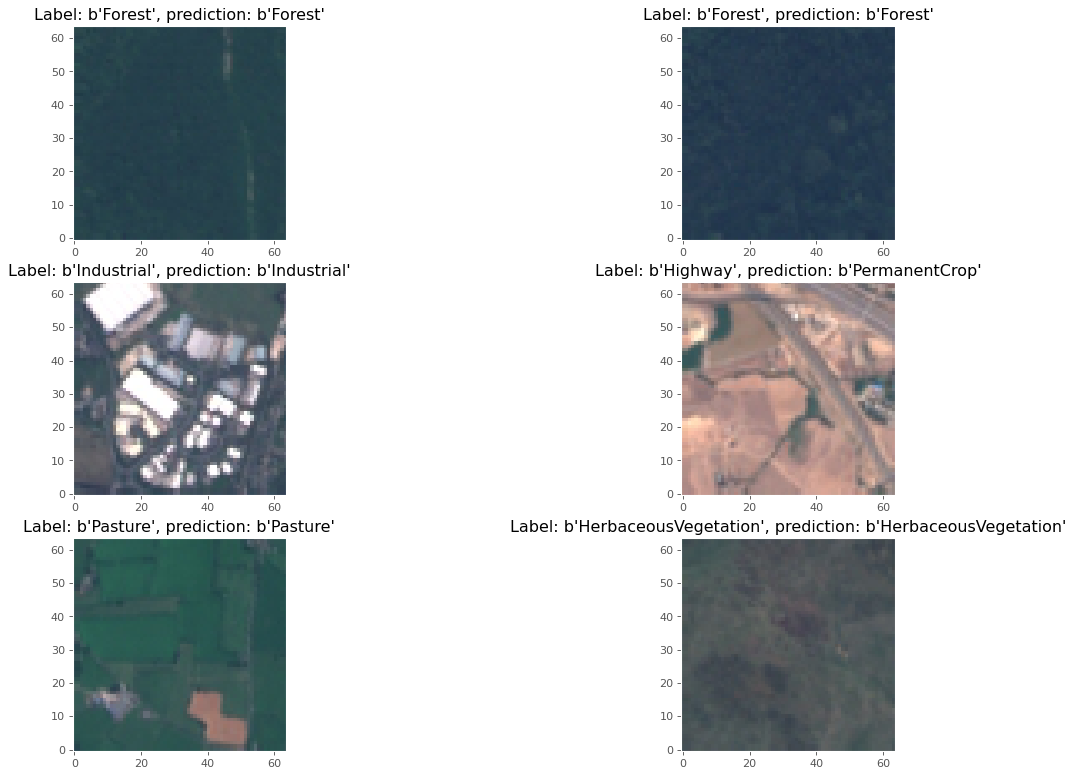

In [109]:
# Посмотрим на несколько картинок
plt.figure(figsize=[18,12])
j = 0
for i in range(2000, 2006):
    plt.subplot(3,2,j+1)
    plt.title("Label: "+str(label_names[y_test_nn[i]])+", prediction: "+str(label_names[y_pred_nn[i].argmax()])) 
    plt.imshow(X_test_nn[i],cmap='gray');
    j = j+1

In [214]:
## End ##of## NN #####

In [310]:
 ## Решейпинг
imgs = np.asarray(io);
reds = imgs[:,:,:,0];
reds2 = reds.reshape(*reds.shape[:-2], -1)

In [311]:
reds2.shape

(54000, 4096)